In [2]:
import datetime
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import hopsworks
import requests
import matplotlib.pyplot as plt
import joblib
import json

today = datetime.datetime.now()
print(f"Inference date: {today}")

Inference date: 2026-01-01 23:35:57.130894


## <span style='color:#ff5f27'> Imports

# <span style="font-width:bold; font-size: 3rem; color:#333;">Batch Inference Pipeline</span>

In [3]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/fingrid from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('fingrid',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env (if running locally)
# In GitHub Actions, environment variables are already set
if os.path.exists(f"{root_dir}/.env"):
    from mlfs import config
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")
else:
    # GitHub Actions environment - settings not needed
    settings = None

Local environment
Added the following directory to the PYTHONPATH: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book\fingrid


## <span style="color:#ff5f27;"> Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()
mr = project.get_model_registry()

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("FINGRID_LOCATION_JSON").value
location = json.loads(location_str)

country = location['country']
city = location['city']

2026-01-01 23:35:57,187 INFO: Initializing external client
2026-01-01 23:35:57,188 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-01 23:35:59,810 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286359


## <span style="color:#ff5f27;">Download the model from Model Registry</span>

In [5]:
# Load the model from local directory
model_path = f"{root_dir}/fingrid/energy_model/energy_consumption_predictor.pkl"
retrieved_xgboost_model = joblib.load(model_path)

print(f"Model loaded from: {model_path}")
retrieved_xgboost_model

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\patri\\VScodeProjects\\25-ID2223-mlfs-book\\fingrid/fingrid/energy_model/energy_consumption_predictor.pkl'

## <span style="color:#ff5f27;">Get Weather Forecast Features</span>

In [ ]:
# Get future weather forecast data (matching airquality pattern)
weather_fg = fs.get_feature_group(
    name='weather_finland',
    version=1,
)
# Get 7 days of FUTURE forecast starting from today
# Read all recent data and filter in pandas to avoid timezone issues
batch_data = weather_fg.read()

# Ensure timezone-naive for filtering
if batch_data['date'].dt.tz is not None:
    batch_data['date'] = batch_data['date'].dt.tz_localize(None)

# Filter for next 7 days
start_date = pd.Timestamp(today.date())
end_date = start_date + pd.Timedelta(days=7)
batch_data = batch_data[
    (batch_data['date'] >= start_date) & (batch_data['date'] < end_date)
].copy()

print(f"Weather forecast data: {len(batch_data)} rows from {start_date.date()} to {end_date.date()}")
print(f"Date range: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique days: {batch_data['date'].dt.date.nunique()}")
batch_data.head()

NameError: name 'fs' is not defined

In [ ]:
# Diagnose weather forecast data
print(f"Total rows fetched: {len(batch_data)}")
print(f"Date range in weather data: {batch_data['date'].min()} to {batch_data['date'].max()}")
print(f"Unique dates: {batch_data['date'].dt.date.nunique()}")

print(f"\nRows per date:")
print(batch_data['date'].dt.date.value_counts().sort_index())

print(f"\nFirst few rows:")
print(batch_data[['date', 'temperature_2m', 'wind_speed_10m']].head(20))

Total rows fetched: 2
Date range in weather data: 2026-01-01 18:00:00+00:00 to 2026-01-01 21:00:00+00:00
Unique dates: 1

Rows per date:
date
2026-01-01    2
Name: count, dtype: int64

First few rows:
                       date  temperature_2m  wind_speed_10m
0 2026-01-01 18:00:00+00:00       -4.366667       25.966667
1 2026-01-01 21:00:00+00:00       -4.066667       28.533333


### <span style="color:#ff5f27;">Add Temporal Features</span>

In [ ]:
# Add temporal features to forecast data
batch_data['year'] = batch_data['date'].dt.year
batch_data['month'] = batch_data['date'].dt.month
batch_data['day'] = batch_data['date'].dt.day
batch_data['hour'] = batch_data['date'].dt.hour
batch_data['day_of_week'] = batch_data['date'].dt.dayofweek
batch_data['is_weekend'] = (batch_data['day_of_week'] >= 5).astype(int)
batch_data['week_of_year'] = batch_data['date'].dt.isocalendar().week

print("Features created:")
print(batch_data.columns.tolist())
batch_data.head()

Features created:
['date', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'country', 'year', 'month', 'day', 'hour', 'day_of_week', 'is_weekend', 'week_of_year']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,year,month,day,hour,day_of_week,is_weekend,week_of_year
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,2026,1,1,18,3,0,1
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,2026,1,1,21,3,0,1


### <span style="color:#ff5f27;">Add Cyclic Features</span>

Convert temporal features to cyclic encoding (matching training pipeline)

In [ ]:
# Add cyclic encoding for month (12 months in a year)
batch_data['month_sin'] = np.sin(2 * np.pi * batch_data['month'] / 12)
batch_data['month_cos'] = np.cos(2 * np.pi * batch_data['month'] / 12)

# Add cyclic encoding for hour (24 hours in a day)
batch_data['hour_sin'] = np.sin(2 * np.pi * batch_data['hour'] / 24)
batch_data['hour_cos'] = np.cos(2 * np.pi * batch_data['hour'] / 24)

# Add cyclic encoding for day_of_week (7 days in a week)
batch_data['day_of_week_sin'] = np.sin(2 * np.pi * batch_data['day_of_week'] / 7)
batch_data['day_of_week_cos'] = np.cos(2 * np.pi * batch_data['day_of_week'] / 7)

print("Cyclic features added")
batch_data.head()

Cyclic features added


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,hour,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,...,18,3,0,1,0.5,0.866025,-1.000000,-1.836970e-16,0.433884,-0.900969
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,...,21,3,0,1,0.5,0.866025,-0.707107,7.071068e-01,0.433884,-0.900969


### <span style="color:#ff5f27;">Making the predictions</span>

In [ ]:
# Drop columns not used for prediction (including original cyclic features)
cols_to_drop = [col for col in ['consumption', 'date', 'country', 'month', 'hour', 'day_of_week'] if col in batch_data.columns]
X_pred = batch_data.drop(columns=cols_to_drop)

# Reorder columns to match the training data order
expected_order = ['year', 'day', 'is_weekend', 'week_of_year', 
                  'temperature_2m', 'precipitation', 'cloud_cover', 
                  'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 
                  'surface_pressure', 'shortwave_radiation',
                  'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 
                  'day_of_week_sin', 'day_of_week_cos']

# Only use columns that exist in both lists
X_pred = X_pred[[col for col in expected_order if col in X_pred.columns]]

print(f"Dropped columns: {cols_to_drop}")
print(f"Features for prediction: {list(X_pred.columns)}")

# Make predictions
batch_data['predicted_consumption'] = retrieved_xgboost_model.predict(X_pred)
batch_data

Dropped columns: ['date', 'country', 'month', 'hour', 'day_of_week']
Features for prediction: ['year', 'day', 'is_weekend', 'week_of_year', 'temperature_2m', 'precipitation', 'cloud_cover', 'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m', 'surface_pressure', 'shortwave_radiation', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']


,date,temperature_2m,precipitation,cloud_cover,wind_speed_10m,wind_speed_100m,wind_direction_10m,surface_pressure,shortwave_radiation,country,...,day_of_week,is_weekend,week_of_year,month_sin,month_cos,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,predicted_consumption
0,2026-01-01 18:00:00+00:00,-4.366667,0.0,100.0,25.966667,38.333333,122.333333,989.500000,0.0,Finland,...,3,0,1,0.5,0.866025,-1.000000,-1.836970e-16,0.433884,-0.900969,8628.415039
1,2026-01-01 21:00:00+00:00,-4.066667,0.0,100.0,28.533333,42.300000,118.666667,987.566667,0.0,Finland,...,3,0,1,0.5,0.866025,-0.707107,7.071068e-01,0.433884,-0.900969,8424.489258


### Create Forecast Graph

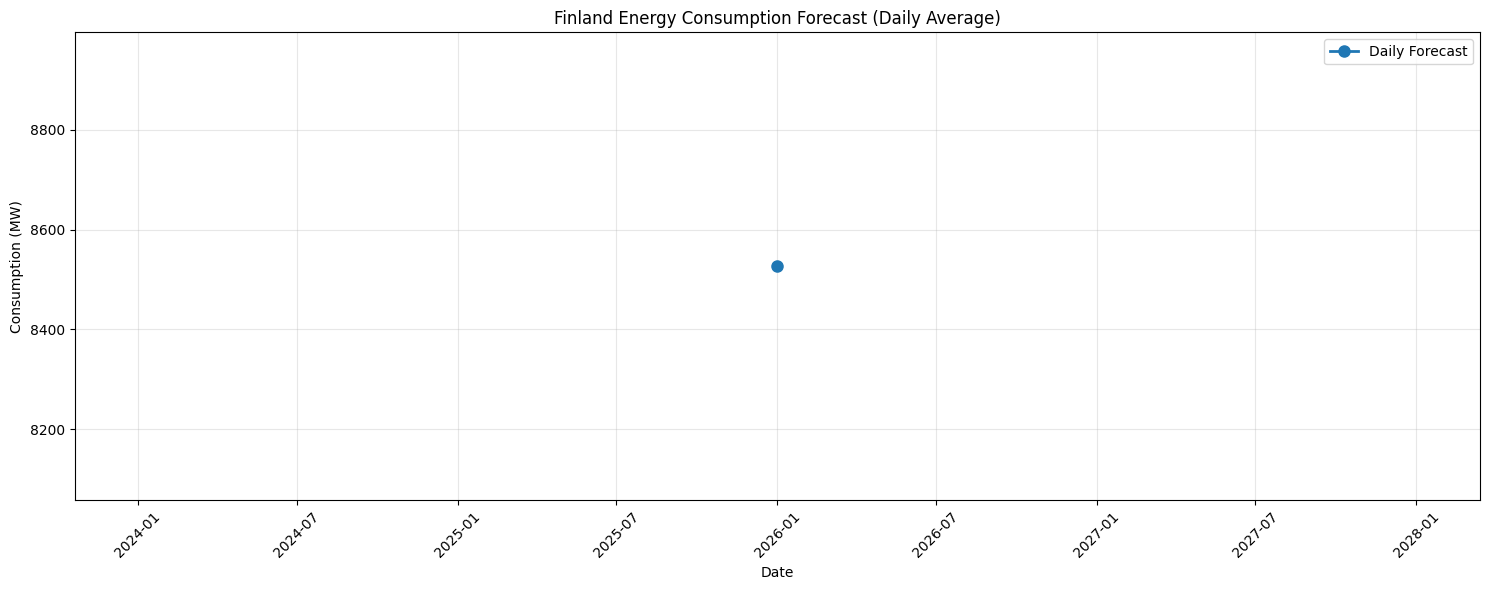

Forecast saved to: c:\Users\patri\VScodeProjects\25-ID2223-mlfs-book/docs/fingrid/assets/img/energy_forecast.png
Forecasting 1 days


In [ ]:
# Resample to daily averages for cleaner visualization
batch_data['date'] = pd.to_datetime(batch_data['date'])
df_daily = batch_data.set_index('date').resample('D')[['predicted_consumption']].mean().reset_index()

# Plot forecast
plt.figure(figsize=(15, 6))
plt.plot(df_daily['date'], df_daily['predicted_consumption'], 
         linewidth=2, marker='o', markersize=8, label='Daily Forecast')
plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption Forecast (Daily Average)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
pred_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_forecast.png"
os.makedirs(os.path.dirname(pred_file_path), exist_ok=True)
plt.savefig(pred_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Forecast saved to: {pred_file_path}")
print(f"Forecasting {len(df_daily)} days")

### <span style="color:#ff5f27;">Saving the predictions to a Monitoring Feature Group</span>

In [ ]:
# Add metadata for monitoring
batch_data['country'] = 'Finland'
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])

# Keep only relevant columns for monitoring
monitoring_data = batch_data[['date', 'country', 'days_before_forecast_day', 'predicted_consumption']].copy()

# Get or create monitoring feature group
monitor_fg = fs.get_or_create_feature_group(
    name='energy_predictions',
    description='Energy consumption prediction monitoring',
    version=1,
    primary_key=['country','date','days_before_forecast_day'],
    event_time="date"
)

monitor_fg.insert(monitoring_data, wait=True)
print(f"Inserted {len(monitoring_data)} predictions into monitoring feature group")

Uploading Dataframe: 100.00% |██████████| Rows 50/50 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: energy_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286359/jobs/named/energy_predictions_1_offline_fg_materialization/executions
2026-01-01 15:44:25,472 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-01 15:44:31,818 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-01 15:46:03,923 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2026-01-01 15:46:04,080 INFO: Waiting for log aggregation to finish.
2026-01-01 15:46:12,740 INFO: Execution finished successfully.
Inserted 50 predictions into monitoring feature group


### <span style="color:#ff5f27;">Create Hindcast - Compare Predictions vs Actual</span>

This shows how well the 1-day-ahead predictions matched actual consumption.

In [ ]:
# Get historical predictions made 1 day before
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
print(f"Historical predictions: {len(monitoring_df)} rows")
monitoring_df.head()

In [ ]:
# Get actual energy consumption data
energy_fg = fs.get_feature_group(name='energy_consumption', version=1)
energy_df = energy_fg.read()
print(f"Actual consumption data: {len(energy_df)} rows")
energy_df.head()

In [ ]:
# Resample actual consumption to daily averages
energy_df['date'] = pd.to_datetime(energy_df['date'])
energy_daily = energy_df.set_index('date').resample('D')[['consumption_mw']].mean().reset_index()
energy_daily = energy_daily.rename(columns={'consumption_mw': 'actual_consumption'})

# Resample predictions to daily averages
if len(monitoring_df) > 0:
    monitoring_df['date'] = pd.to_datetime(monitoring_df['date'])
    preds_daily = monitoring_df.set_index('date').resample('D')[['predicted_consumption']].mean().reset_index()
    
    # Merge predictions with actuals
    hindcast_df = pd.merge(preds_daily, energy_daily, on='date', how='inner')
    hindcast_df = hindcast_df.sort_values(by=['date'])
    print(f"Hindcast data points: {len(hindcast_df)}")
else:
    hindcast_df = pd.DataFrame()
    print("No historical predictions yet for hindcast")

hindcast_df.head()

### <span style="color:#ff5f27;">Plot Hindcast</span>

__This graph will be empty initially - this is normal.__

After a few days of predictions and observations, you will see data points comparing predictions vs actual consumption.

In [ ]:
plt.figure(figsize=(15, 6))

if len(hindcast_df) > 0:
    plt.plot(hindcast_df['date'], hindcast_df['actual_consumption'], 
             linewidth=2, marker='o', markersize=8, label='Actual Consumption', color='blue')
    plt.plot(hindcast_df['date'], hindcast_df['predicted_consumption'], 
             linewidth=2, marker='s', markersize=8, label='Predicted (1-day ahead)', 
             color='red', linestyle='--')
else:
    plt.text(0.5, 0.5, 'Waiting for historical data...', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('Date')
plt.ylabel('Consumption (MW)')
plt.title('Finland Energy Consumption Hindcast (1-Day Ahead Predictions)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
hindcast_file_path = f"{root_dir}/docs/fingrid/assets/img/energy_hindcast.png"
os.makedirs(os.path.dirname(hindcast_file_path), exist_ok=True)
plt.savefig(hindcast_file_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Hindcast saved to: {hindcast_file_path}")